学習と予測をやってみる

参考になりそうなサイト  
Prior and Posterior Predictive Checks  
https://docs.pymc.io/notebooks/posterior_predictive.html  
    
PyStan / PyMC3 でベイズ統計モデリング  
https://qiita.com/0NE_shoT_/items/2b41ae3e8e8f2d8809c4

GLM in PyMC3: Out-Of-Sample Predictions  
https://juanitorduz.github.io/glm_pymc3/

# Prior and Posterior Predictive Checks

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy.special import expit as logistic

RANDOM_SEED = 58

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

# 線形モデルの設定

PyMC3チュートリアルの$predictor$、$outcome$ではわかりにくいので、$x$, $y$ で表すことにする。

$\mu = a + b x$  
$y - \mu = y - (a + bx) \sim N(0, \sigma)$

In [3]:
# numpyの乱数シード固定
np.random.seed(seed=RANDOM_SEED)

In [4]:
N = 100

true_a, true_b, x = 0.5, 3.0, np.random.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * x
true_sd = 2.0

y = np.random.normal(loc=true_mu, scale=true_sd, size=N)

f"{x.mean():.2f}, {x.std():.2f}, {y.mean():.2f}, {y.std():.2f}"

'2.42, 5.84, 7.75, 17.62'

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


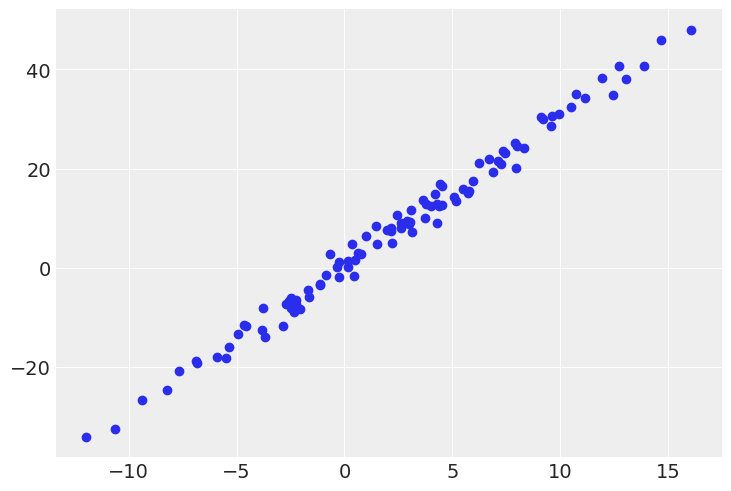

In [5]:
plt.scatter(x, y)

# 前処理

標準化する。  
以下の記事にある通り、前処理で標準化したほうが、収束が早くなるなど実用的にはメリットがあるようだ。
https://gaiasky.hatenablog.com/entry/2018/08/18/204331

In [6]:
x_scaled = standardize(x)
y_scaled = standardize(y)

f"{x_scaled.mean():.2f}, {x_scaled.std():.2f}, {y_scaled.mean():.2f}, {y_scaled.std():.2f}"

'0.00, 1.00, 0.00, 1.00'

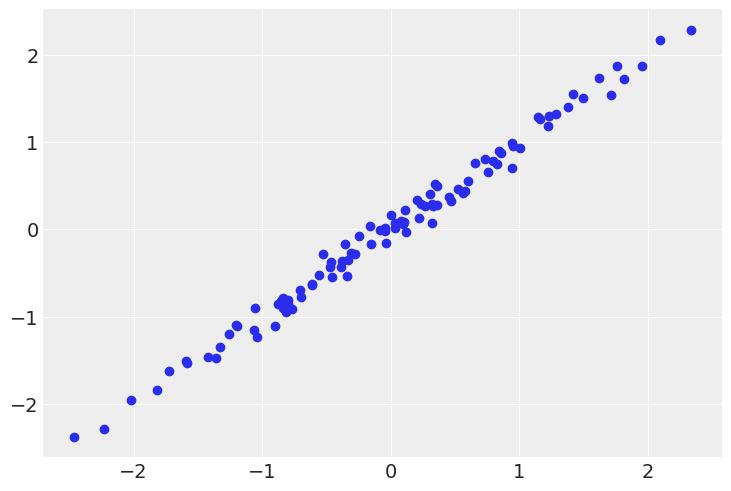

In [7]:
plt.scatter(x_scaled, y_scaled)

In [8]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * x_scaled
    sd = pm.Exponential("sd", 1.0)

    y_obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y_scaled)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

In [9]:
prior_checks

{'obs': array([[  8.27010271,  18.67088144,   8.7078053 , ...,  -3.14612169,
          -2.59070913,  -4.75177754],
        [ 26.2309133 ,  55.60904024,  27.33155353, ...,  -5.9294833 ,
          -3.83994119,  -8.72117308],
        [  9.96345379,  22.45618205,   9.98219908, ...,  -1.30752075,
           0.53069117,  -1.76658347],
        ...,
        [  5.96832542,   0.14413765,   5.12632615, ...,  10.19179103,
           8.91051773,   7.9228828 ],
        [ -5.69768369, -25.96977537,  -6.19166752, ...,  14.96260017,
          14.75262018,  19.71544401],
        [ -7.83651348, -35.15987573,  -8.91448147, ...,  21.77733254,
          19.99694338,  25.62265132]]),
 'sd_log__': array([-2.64551112e+00,  4.26910792e-04, -1.96489378e-01, -9.80719898e-01,
        -2.37502060e+00, -1.00963684e+00,  3.14803354e-01, -1.41631221e+00,
         9.51643729e-01, -8.10036760e-01,  1.47886619e+00, -1.11106517e+00,
        -2.15124000e+00, -1.46279969e+00, -3.32691035e-02, -4.04019681e+00,
        -8.717

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


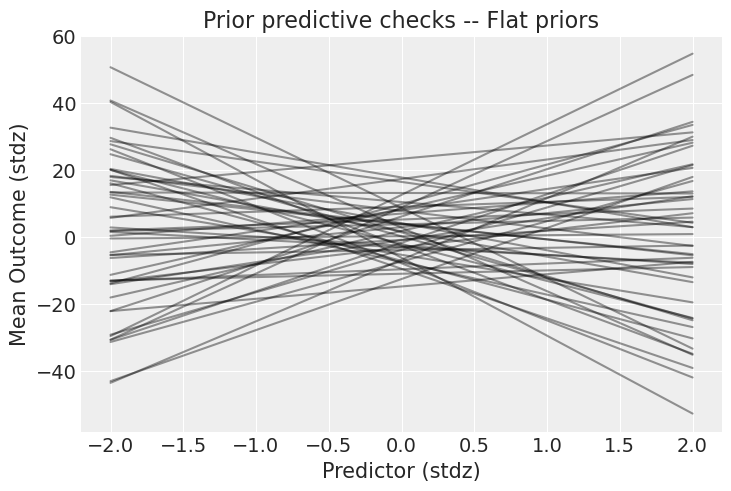

In [10]:
_, ax = plt.subplots()

xx = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    yy = a + b * xx
    ax.plot(xx, yy, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

↑前処理した標準化後のxとyのプロットと比較して、yが $O(10)$ 大きい。  
標準化しているのに、$a$と$b$の事前分布に設定した標準偏差が大きすぎることが原因。

In [11]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * x_scaled
    sd = pm.Exponential("sd", 1.0)

    y_obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y_scaled)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

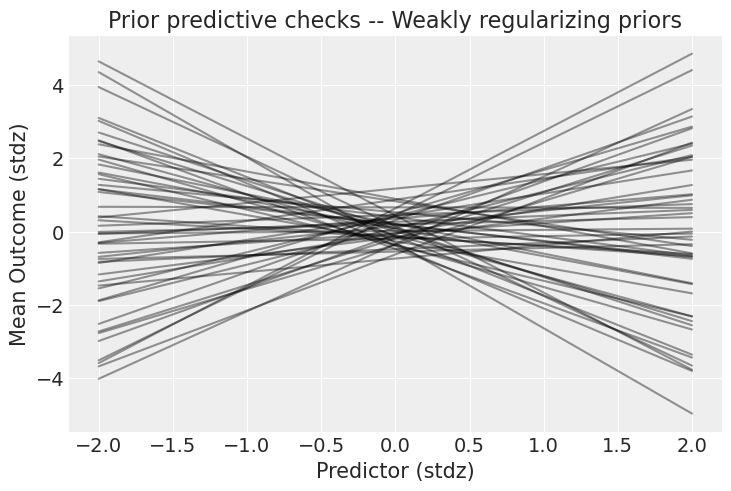

In [12]:
_, ax = plt.subplots()

xx = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    yy = a + b * xx
    ax.plot(xx, yy, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

In [13]:
%%time
with model_1:
    trace_1 = pm.sample(1000,#The number of samples to draw
                        tune=2000, #Number of iterations to tune 
                        random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


Wall time: 24.5 s


In [14]:
trace_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


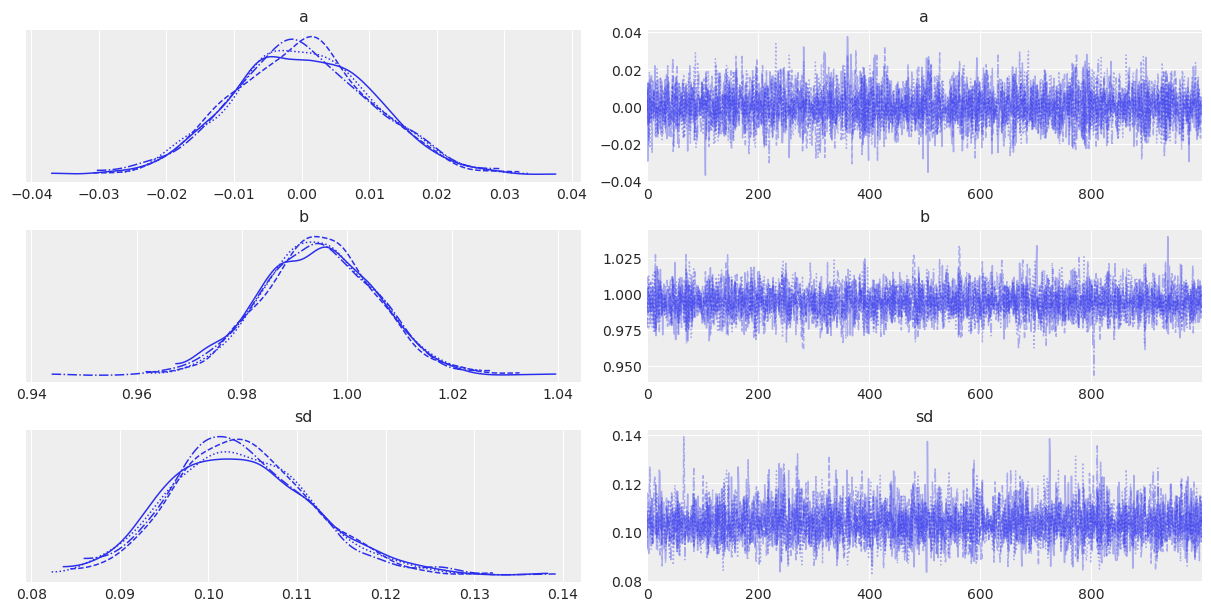

In [15]:
with model_1:
    az.plot_trace(trace_1);

## Posterior Predictive Check

In [16]:
with model_1:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED
    )

In [17]:
ppc

{'a': array([ 0.00910097, -0.02942329, -0.01026803, ...,  0.00343316,
        -0.00524792,  0.00090462]),
 'b': array([0.99012939, 1.0006785 , 1.00408654, ..., 0.98334461, 1.0057311 ,
        0.98342077]),
 'obs': array([[-0.91704726, -2.42644849, -0.97282626, ...,  0.73196218,
          0.63428261,  0.94234916],
        [-0.86299786, -2.3237155 , -1.12182037, ...,  0.71817884,
          0.40403953,  0.87105845],
        [-0.91587113, -2.35797782, -0.97957739, ...,  0.61065302,
          0.54561638,  0.86493388],
        ...,
        [-0.66156931, -2.20391963, -0.72427308, ...,  0.59657311,
          0.79669118,  0.71096905],
        [-0.82539455, -2.12887984, -0.95790707, ...,  0.68372453,
          0.67012172,  0.7506722 ],
        [-0.74901035, -2.15901521, -0.95204921, ...,  0.75789691,
          0.55535319,  0.99952293]])}

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


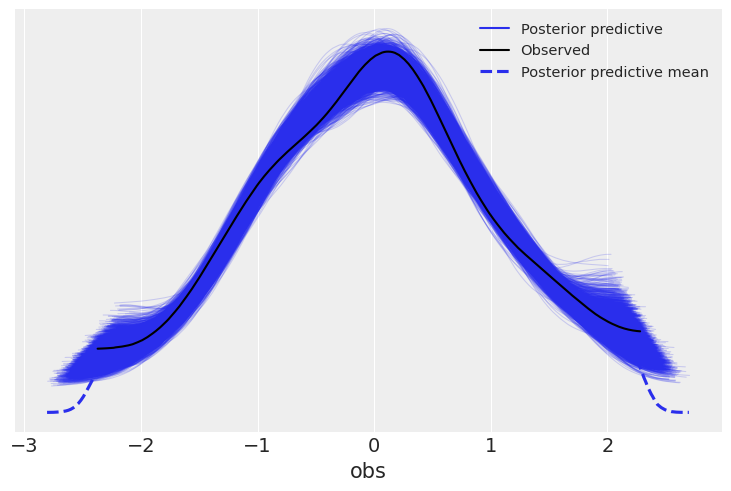

In [18]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_1));

↑上のPosterior Predictiveにはsdがパラメータとして入っていない気がする。念のためsdも入れてやってみる。

In [19]:
with model_1:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["a", "b", "sd", "obs"], random_seed=RANDOM_SEED
    )

In [20]:
ppc

{'a': array([ 0.00910097, -0.02942329, -0.01026803, ...,  0.00343316,
        -0.00524792,  0.00090462]),
 'b': array([0.99012939, 1.0006785 , 1.00408654, ..., 0.98334461, 1.0057311 ,
        0.98342077]),
 'sd': array([0.10828426, 0.10258491, 0.09383481, ..., 0.105558  , 0.09532888,
        0.10858239]),
 'obs': array([[-0.91704726, -2.42644849, -0.97282626, ...,  0.73196218,
          0.63428261,  0.94234916],
        [-0.86299786, -2.3237155 , -1.12182037, ...,  0.71817884,
          0.40403953,  0.87105845],
        [-0.91587113, -2.35797782, -0.97957739, ...,  0.61065302,
          0.54561638,  0.86493388],
        ...,
        [-0.66156931, -2.20391963, -0.72427308, ...,  0.59657311,
          0.79669118,  0.71096905],
        [-0.82539455, -2.12887984, -0.95790707, ...,  0.68372453,
          0.67012172,  0.7506722 ],
        [-0.74901035, -2.15901521, -0.95204921, ...,  0.75789691,
          0.55535319,  0.99952293]])}

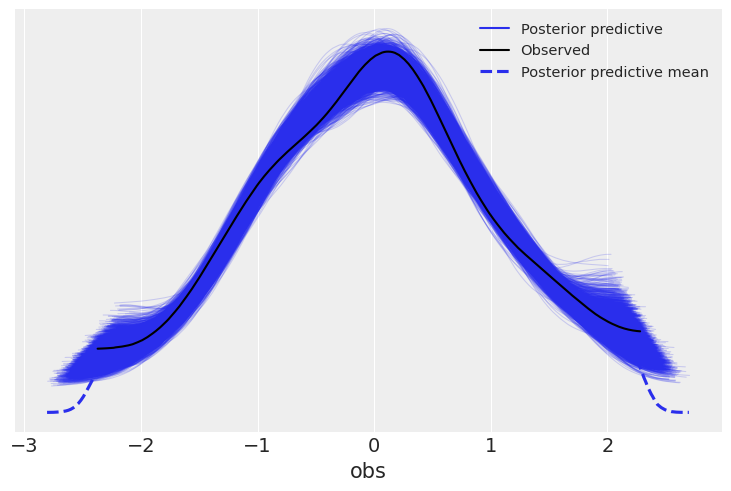

In [21]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_1));

結果はsdを入れてもあまり変わりなし。

plot_hdiなら通る、記事の通りplot_hpdならエラーとなる。バージョンの違いか？

C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


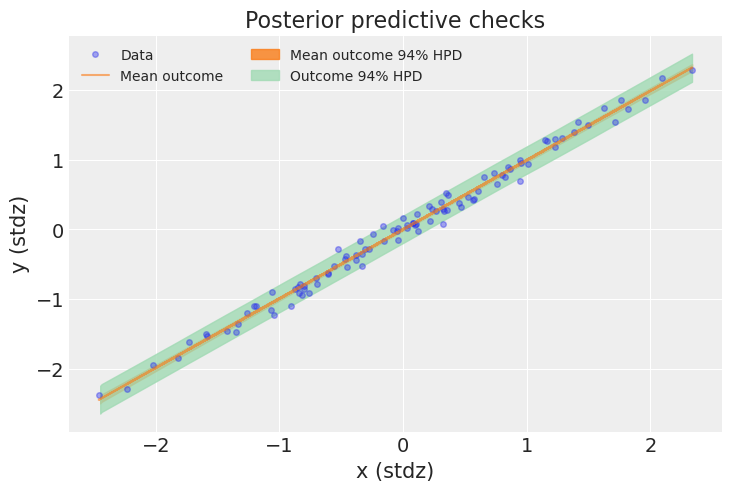

In [22]:
mu_pp = (ppc["a"] + ppc["b"] * x_scaled[:, None]).T

_, ax = plt.subplots()

ax.plot(x_scaled, y_scaled, "o", ms=4, alpha=0.4, label="Data")
ax.plot(x_scaled, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hdi(
    x_scaled,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hdi(
    x_scaled,
    ppc["obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.set_xlabel("x (stdz)")
ax.set_ylabel("y (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

## 前処理なしでやってみる

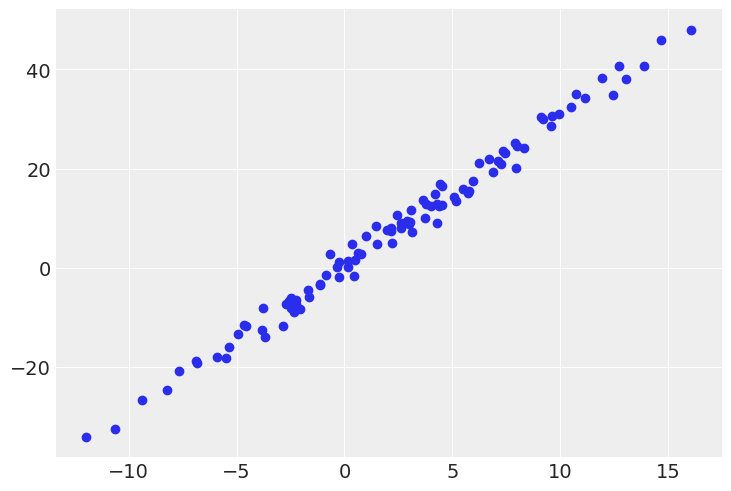

In [23]:
plt.scatter(x,y)

In [24]:
with pm.Model() as model_0:
    a = pm.Normal("a", 0.0, 2.0)
    b = pm.Normal("b", 0.0, 2.0)

    mu = a + b * x
    sd = pm.Exponential("sd", 1.0)

    y_obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

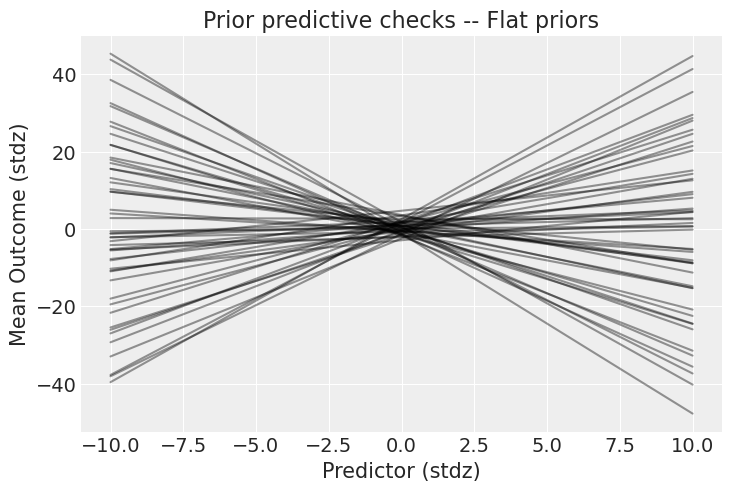

In [25]:
_, ax = plt.subplots()

x = np.linspace(-10, 10, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [26]:
%%time
with model_0:
    trace_0 = pm.sample(draws=1000,#The number of samples to draw
                        tune=2000, #Number of iterations to tune 
                        random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.


Wall time: 25.4 s


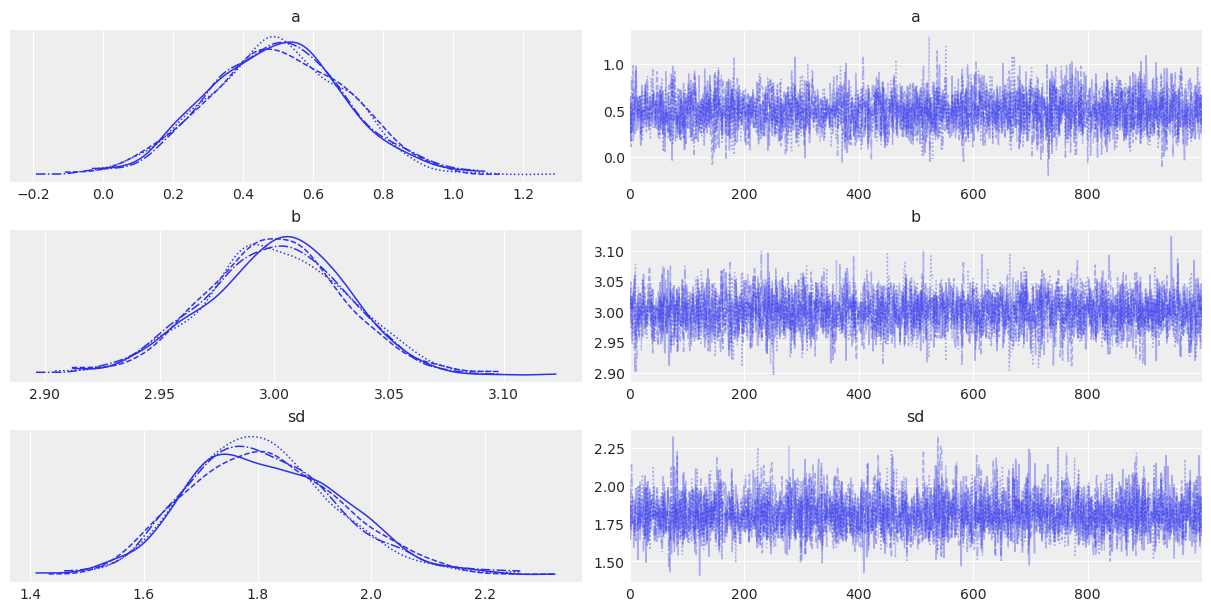

In [27]:
with model_0:
    az.plot_trace(trace_0);

↑標準化しない場合、1秒くらい計算時間が多くかかる。結果は妥当なものが得られている。

# Prediction

Logistic regression model is used.

In [29]:
N = 400
true_intercept = 0.2
true_slope = 1.0

np.random.seed(seed=RANDOM_SEED)
x = np.random.normal(size=N)

true_p = logistic(true_intercept + true_slope * x)

np.random.seed(seed=RANDOM_SEED)
y = np.random.binomial(1, true_p)

y

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,

In [30]:
y.sum()/len(y)

0.5175

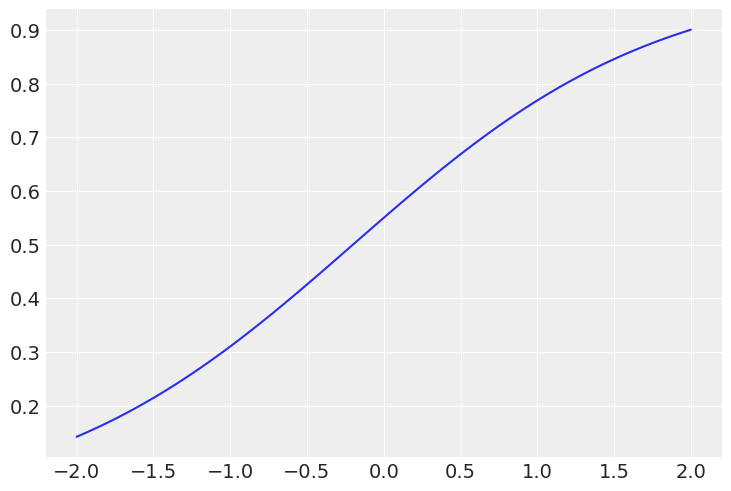

In [31]:
xx = np.linspace(-2,2,100)
yy = logistic(true_intercept + true_slope * xx)
plt.plot(xx,yy)

In [32]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    x_data = pm.Data("x_data", x) # pred -> x_data
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * x_data))
    
    y_pbs = pm.Bernoulli("y_pbs", p=p, observed=y)
    
    trace_2 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True)
    
az.summary(trace_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.14,0.11,-0.07,0.34,0.0,0.0,3183.91,2653.16,1.0
betas[1],1.04,0.14,0.79,1.31,0.0,0.0,3039.65,2748.28,1.0


Now, let’s simulate **out-of-sample data**  to see how the model predicts them

In [33]:
x_out_of_sample = np.random.normal(size=50)

y_out_of_sample = np.random.binomial(
    1, logistic(true_intercept + true_slope * x_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"x_data": x_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace_2, var_names=["p"], random_seed=RANDOM_SEED
    )
    model_preds = posterior_predictive["p"]

In [34]:
model_preds.shape

(4000, 50)

4000回のサンプリングを実施して、50個アウトサンプルに対する予測の分布を求めている

In [35]:
az.hdi(model_preds).T

C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


array([[0.11593379, 0.4187348 , 0.40941399, 0.73946141, 0.58757638,
        0.81580311, 0.62780783, 0.2520021 , 0.35713739, 0.45339945,
        0.77057381, 0.17539322, 0.64945269, 0.57211301, 0.44584096,
        0.52585962, 0.87892233, 0.41884182, 0.77390054, 0.79626765,
        0.51058118, 0.39727738, 0.28610973, 0.4986508 , 0.31097355,
        0.71656761, 0.80734145, 0.60995034, 0.60977862, 0.5722449 ,
        0.21710147, 0.40767897, 0.6298943 , 0.56079787, 0.5749199 ,
        0.52178477, 0.71630987, 0.50555499, 0.59680675, 0.52362757,
        0.4176366 , 0.46041233, 0.71721638, 0.68639852, 0.4131032 ,
        0.31052705, 0.60773993, 0.68247914, 0.82527119, 0.75666579],
       [0.24394997, 0.52172571, 0.51360709, 0.86290815, 0.69703582,
        0.92661147, 0.74440277, 0.37513585, 0.4662923 , 0.55455472,
        0.89089358, 0.30623782, 0.76866537, 0.68021101, 0.54740388,
        0.62962078, 0.96562562, 0.52185343, 0.89398334, 0.91170034,
        0.6133259 , 0.50313225, 0.40475349, 0.6

In [36]:
model_preds.mean(0).shape

(50,)

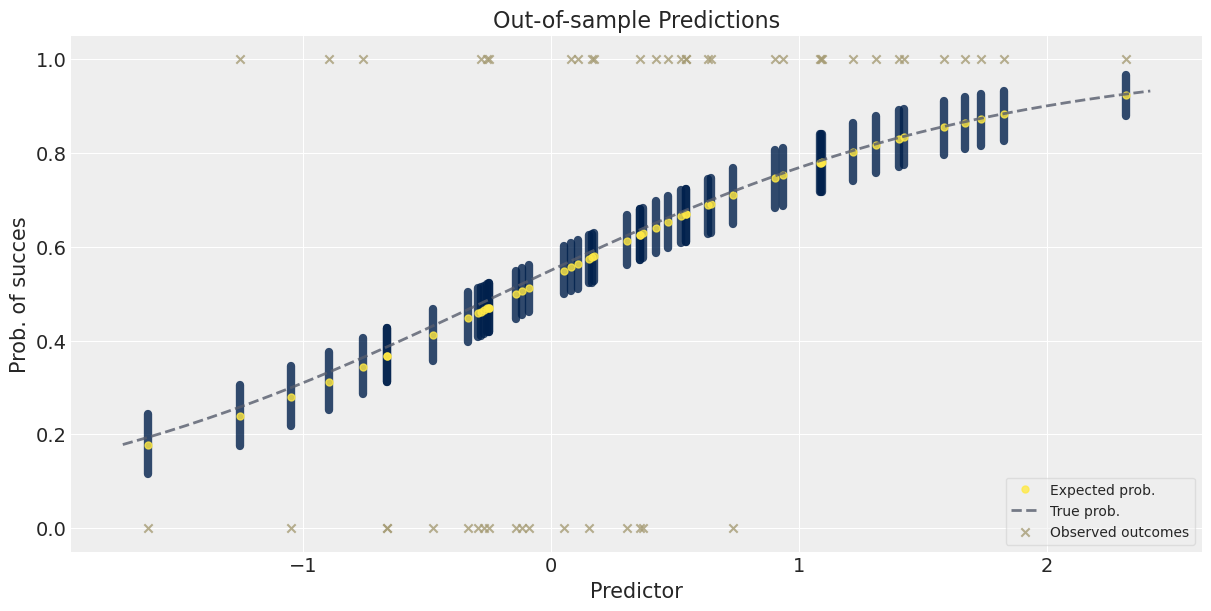

In [37]:
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.plot(
    [x_out_of_sample, x_out_of_sample],
    az.hdi(model_preds).T,
    lw=6,
    color="#00204C",
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    x_out_of_sample,
    model_preds.mean(0),
    "o",
    ms=5,
    color="#FFE945",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=x_out_of_sample,
    y=y_out_of_sample,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)

# true probabilities:
x = np.linspace(x_out_of_sample.min() - 0.1, x_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of succes")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);